TODO
- land mask halo mask
- ice mask

In [1]:
# Working env variables
jupyterhub = True
smalltest = False

In [2]:
if jupyterhub:
    !pip install ..

Processing /home/jovyan/git/llc4320-native-grid-preprocessing
  Installing build dependencies ... one
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbof-in-native-grid: filename=dbof_in_native_grid-0.0.dev0-py3-none-any.whl size=19939 sha256=76e1ca0bc6262846dab33d0294fa75347896cd2382af65c8d237f19eb00e3da0
  Stored in directory: /home/jovyan/.cache/pip/wheels/1a/4c/86/ce01074c4f718570f5d3513e6430e9f97f383cf210efd719bf
Successfully built dbof-in-native-grid
  Attempting uninstall: dbof-in-native-grid
    Found existing installation: dbof-in-native-grid 0.0.dev0
    Uninstalling dbof-in-native-grid-0.0.dev0:
      Successfully uninstalled dbof-in-native-grid-0.0.dev0

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import cmocean
import xgcm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import xmitgcm.llcreader as llcreader

import dask.array as da
from dask.distributed import Client

import tqdm

import xarray as xr
import pandas as pd

import uuid

import zarr

In [4]:
import data_ingestion.get_raw_data as get_raw_data
import utils.native_gradient as ng
import plotting.llc_plotting as llc_plotting

import data_preprocessing.preproc_llc_core_data as preproc_llc_core_data
import utils.physical_calculations as physical_calculations

import data_preprocessing.weighted_coordinate_sampling as weighted_coordinate_sampling

import data_preprocessing.halo_mask as halo_mask

import data_preprocessing.spatial_patches as spatial_patches

import dataset_creation.metadata as metadata

import data_preprocessing.stats as stats



In [5]:
feature_channels = ["Eta", "Salt", "Theta", "U", "V", "W", "log_gradb"]
target_km_res = 150 #km
down_sample_res = 64 #pixels
halo_km = target_km_res #/2

In [6]:
# set up dask distributed client
dask_client = Client()  # default: uses all local cores
dask_client

/opt/conda/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40889 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:40889/status,
Dashboard: http://127.0.0.1:40889/status,Workers: 8
Total threads: 32,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35775,Workers: 0
Dashboard: http://127.0.0.1:40889/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45937,Total threads: 4
Dashboard: http://127.0.0.1:34853/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36977,


In [7]:
# loop through all existing files

timestep_hours = 12                     # how many hours to load
sampling_step = 12                      # stride in timesteps
ts_per_hour = 144                       # model cadence: 25 s → 144 steps/hr
iter_step = sampling_step * ts_per_hour # iteration Δ between samples
face_range = range(13)

# NOTE MAX iteration : 1495008

# First valid wind/forcing record begins ~1180
start_record = 1180

# Compute iter numbers
start_iter = 10368 + start_record * ts_per_hour
end_iter = 1495008 #start_iter + timestep_hours * ts_per_hour
iter_range = np.arange(start_iter, end_iter, iter_step)

endpoint_url = 'https://mghp.osn.xsede.org'

In [8]:
# files = []
# for it in iter_range:
#     files.append(get_raw_data.get_remote_llc_data(endpoint_url, it, face_range))

In [9]:
it = iter_range[0]

co = get_raw_data.get_remote_gridfile(endpoint_url)
ds = get_raw_data.get_remote_llc_data(endpoint_url, it, face_range)

ds_merge, ds_grid = preproc_llc_core_data.process_llc4320(ds, co)


Opening 13 Kerchunk JSON files...
Parsing JSON metadata into Python dicts...
Creating lazy xarray datasets...
Computing delayed datasets...
Combining datasets by coordinates...
Dataset combined successfully.


In [10]:
if smalltest:
    ds_merge = ds_merge.isel(face = slice(0,1)) # grab the first face but keep face coords
    ds_grid = ds_grid.isel(face= slice(0,1))

# grid = xgcm.Grid(ds_grid, coords={'X':{'center':'XC'}}, periodic=False)
grid = xgcm.Grid(ds_grid, periodic=False)

In [11]:
# llc_plotting.plot_llc_faces_layout( ds_merge.Theta, vmin=-4, vmax=40 )

In [ ]:
# first order approximation of freezing point
#tf = -0.056S - 0.008
freezing_point_tol = 0.5 #0.05
ice_mask = ds_merge.Theta <= ((-0.056*ds_merge.Salt) - 0.008 + freezing_point_tol)

# ice_mask = ds_merge.Theta <= -1.8
# ice_mask = ds_merge.Theta <= 0.0

halo_land_mask = halo_mask.llc_halo_mask(
    mask=ds_grid.hFacC == 0,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

halo_ice_mask = halo_mask.llc_halo_mask(
    mask=ice_mask,
    dxC=ds_grid["dxC"],
    dyC=ds_grid["dyC"],
    halo_km=halo_km
)

merged_mask = halo_ice_mask & halo_land_mask

In [ ]:
# print("da.dims:", ds_merge.dims)
# print("mask.dims:", merged_mask.dims)

In [ ]:
# cmap_bool = colors.ListedColormap(['red', 'green'])

# #llc_plotting.plot_a_face_by_var(xr.DataArray(merged_mask), 0, color_map=cmap_bool, vmin=0, vmax=1)
# llc_plotting.plot_llc_faces_layout(xr.DataArray(merged_mask), color_map=cmap_bool, is_mask=True, vmin=0, vmax=1)

In [ ]:
# Meridional and Zonal Gradient of theta
ds_dx_hatx_G, ds_dy_haty_G = ng.calculate_native_gradient_tracer(ds_merge.Theta, ds_grid, grid=grid)

In [ ]:
buoyancy = physical_calculations.buoyancy_of_field(ds_merge)

# gradient of b
zonal_grad_b, merid_grad_b = ng.calculate_native_gradient_tracer(buoyancy, ds_grid, grid=grid)

zonal_grad_b = zonal_grad_b.persist()
merid_grad_b = merid_grad_b.persist()

gradb2 = physical_calculations.grad_squared(zonal_grad_b, merid_grad_b)
gradb2 = gradb2.persist()


log_gradb = da.log10(gradb2)
log_gradb.persist()

log_gradb_ds = log_gradb.to_dataset(name="log_gradb")
ds_merge = xr.merge([ds_merge, log_gradb_ds])

# Sample data points weighted toward high gradient values

## Option 1 : Sample from gradients directly on the grid

This is the best option I believe

slowish

In [ ]:
# llc_plotting.plot_llc_faces_layout(log_gradb)

In [ ]:
bias_to_high_gradients = 10 # 0.5  # < 1 flattens, > 1 sharpens

SAMPLE_POINTS = 100 # todo what do we want here?

if smalltest:
    SAMPLE_POINTS = 50

In [ ]:
# display weights
# todo update sampling with this logic 

# make the weights positive 
weights = log_gradb - log_gradb.min()

weights = weights ** bias_to_high_gradients # power law
weights = weights.where(merged_mask)
p = weights / weights.sum()
llc_plotting.plot_llc_faces_layout(p, vmin=1e-5, vmax=1.3e-5)

In [ ]:
# # sample on grid
indices = weighted_coordinate_sampling.weighted_sample_on_grid(SAMPLE_POINTS, bias_to_high_gradients, log_gradb, merged_mask)

# TODO display weights mask

## Option 2 Sample from pdf and find matching values in the grid

In [ ]:
# x = log_gradb.values  # loads data into memory
#
# samples = weighted_coordinate_sampling.sample_linearly_on_pdf(x, SAMPLE_POINTS, False)
# tolerance = 5e-7
# indices2 = weighted_coordinate_sampling.find_coords_first_parallel(x, samples, tol=tolerance, n_jobs=3) # this uses a lot of ram but is pretty fast

# Generate Spatial Patches from Our Indices

# Meta data :

id
location : lat lon corners and center
Actual : km size, resolution
gradb center point value


In [ ]:
# Move non tracer values to tracer points
# only run this once or weird stuff happens
ds_merge["V"] = grid.interp(ds_merge["V"], 'Y', boundary='fill')
ds_merge["U"] = grid.interp(ds_merge["U"], 'X', boundary='fill')

In [ ]:
# set up metadata
meta_data_filename = "metadata" # todo s3 location
meda_data_file_path = meta_data_filename + ".parquet"

metadata_cols = [
    "id",
    "dataset_index",
    "native_grid",
    "center_grid_face",
    "center_grid_j",
    "center_grid_i",
    "center_lat",
    "center_lon",
    "target_km_res",
    "real_km_w",
    "real_km_h",
    "pre_interp_res",
    "log_grad_b_2_center",

    "time_snapshot" # todo need info from model docs to get this - could store index for now
]

metadata_writer = metadata.MetadataWriter(meda_data_file_path, flush_every=10000)

In [ ]:
# TODO s3 store and create a class

dataset_path = "dataset.zarr"
store = zarr.open_group(dataset_path, mode="a")

C, H, W = len(feature_channels), down_sample_res, down_sample_res

if "images" not in store:
    store.create_array(
        "images",
        shape=(0, C, H, W),
        chunks=(1, C, H, W),
        dtype="float32"
    )

In [ ]:
def append_image(zstore, img): # todo batch? and make this a class
    zstore["images"].append(np.expand_dims(img, axis=0), axis=0)
    n = store["images"].shape[0]
    return n   # zarr index

In [ ]:
patches = []
print()
# this is our main loop of data creation
# todo parallelize obviously
for index in tqdm.tqdm(indices):
    if index is not None:
        patch_metadata = dict.fromkeys(metadata_cols)
        patch_metadata["id"] = str(uuid.uuid4())
        patch_metadata["native_grid"] = "LLC4320" # todo all supported for now
        patch_metadata["center_grid_face"] = index[0]
        patch_metadata["center_grid_j"] = index[1]
        patch_metadata["center_grid_i"] = index[2]
        patch_metadata["target_km_res"] = target_km_res
        patch_metadata["center_lat"] = ds_merge.YC[index].values.item()
        patch_metadata["center_lon"] = ds_merge.XC[index].values.item()
        patch_metadata["log_grad_b_2_center"] = (ds_merge.log_gradb[index].values.item())

        patch = spatial_patches.get_lat_lon_extents_of_patch(index, ds_merge, target_km_res)

        if(patch is None):
            continue # todo we should log this somehow

        patches.append(patch)

        patch_metadata["real_km_w"] = patch["real_km_w"]
        patch_metadata["real_km_h"] = patch["real_km_h"]

        patch_img = ds_merge.Theta.isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )
        patch_metadata["pre_interp_res"] = patch_img.shape
        # img_patch = spatial_patches.create_image_patch(ds_merge, feature_channels, patch)
        # data_sample = spatial_patches.downsample_image(img_patch)
        
        # # add data to zarr
        # idx = append_image(store, data_sample)
        # patch_metadata["dataset_index"] = idx


        # add metadata
        metadata_writer.add(patch_metadata)

metadata_writer.close()

In [39]:
# note for display we must delete the metadata file before running sampling
meta_df = pd.read_parquet("metadata.parquet")

In [ ]:
meta_df

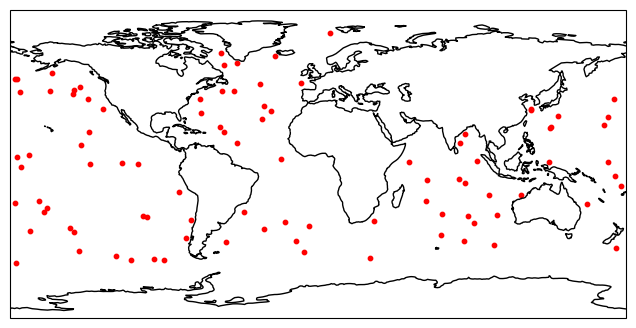

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

lats, lons = meta_df["center_lat"], meta_df["center_lon"]

fig = plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.set_global()
ax.scatter(
    lons,
    lats,
    s=10,
    color="red",
    transform=ccrs.PlateCarree()
)

plt.show()

In [ ]:
meta_df["log_grad_b_2_center"]

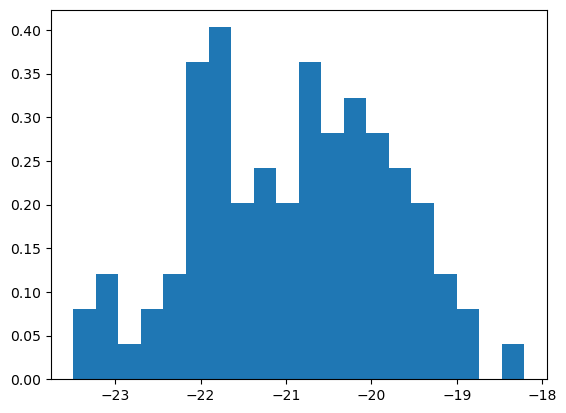

In [41]:
hist, edges = np.histogram(meta_df["log_grad_b_2_center"], bins=20, density=True)

plt.bar(
    edges[:-1],
    hist,
    width=np.diff(edges),
    align="edge"
)

plt.show()

In [ ]:
# # polar point
# latlon_dict = get_lat_lon_extents_of_patch((6, 2159, 2159), log_gradb, ds_merge, 150)
#
# #print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

In [ ]:
# # worst possible point for dx dy ratio 3 0 623
# latlon_dict = get_lat_lon_extents_of_patch((3, 700, 1023), log_gradb, ds_merge, 150)

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(store["images"][0][4],origin='lower',cmap='jet')

In [ ]:

# print(latlon_dict["j_end"]-latlon_dict["j_start"])
# print(latlon_dict["i_end"]-latlon_dict["i_start"])
#
# print(latlon_dict["i_start"], latlon_dict["j_start"], latlon_dict["face"])
#
# print(slice(latlon_dict["j_start"], latlon_dict["j_end"] + 1))
i = 0
for patch in patches:
    # if i >= 1:
    #     break
    if patch is not None:
        patch_img = ds_merge.Theta.isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )

        print(patch_img.shape)

        plt.figure(figsize=(8,8), dpi= 90)
        plt.imshow(patch_img,origin='lower',cmap='jet')
    i+=1

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(data_sample[5],origin='lower',cmap='jet')

In [ ]:
#COMPARE TO ORIGINAL

patch = patches[0]
patch_img = ds_merge["W"].isel(
            face=patch["face"],
            j=slice(patch["j_start"], patch["j_end"] + 1),
            i=slice(patch["i_start"], patch["i_end"] + 1)
        )
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(patch_img,origin='lower',cmap='jet')

# Using zarr build a full dataset


In [ ]:
# print(latlon_dict["lat_min"], latlon_dict["lat_max"], latlon_dict["lon_min"], latlon_dict["lon_max"])

In [ ]:
# from ecco_v4_py import resample_to_latlon
# new_grid_delta_lat = 0.05# 0.05
# new_grid_delta_lon = 0.05#0.05
#
# center_lat = (latlon_dict["lat_min"] + latlon_dict["lat_max"]) / 2
#
# km_per_deg_lat = 111.32
# km_per_deg_lon = 111.32 * np.cos(np.deg2rad(center_lat))
#
# # desired patch half-width in km
# km_res = 0.1 # todo this is not named well
#
# # convert km to degrees
# dlat = km_res / km_per_deg_lat
# dlon = km_res / km_per_deg_lon
#
# print(dlat, dlon)
#
# theta_patch_latlon = resample_to_latlon(
#     ds_merge.XC,
#     ds_merge.YC,
#     ds_merge.Theta,
#     latlon_dict["lat_min"], latlon_dict["lat_max"],
#     dlat,
#     latlon_dict["lon_min"], latlon_dict["lon_max"],
#     dlon,
#     mapping_method='nearest_neighbor'
# )
#
# # theta_patch_latlon = resample_to_latlon(
# #     ds_merge.XC,
# #     ds_merge.YC,
# #     ds_merge.Theta,
# #     lat_min, lat_max,
# #     new_grid_delta_lat,
# #     lon_min, lon_max,
# #     new_grid_delta_lon,
# #     mapping_method='nearest_neighbor'
# # )


In [ ]:
new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

full_interp = resample_to_latlon(
    ds_merge.XC,
    ds_merge.YC,
    ds_merge.Theta,
    new_grid_min_lat, new_grid_max_lat,
    1,
    new_grid_min_lon, new_grid_max_lon,
    1,
    mapping_method='nearest_neighbor'
)



In [ ]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = full_interp

plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

In [ ]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field = theta_patch_latlon

In [ ]:
plt.figure(figsize=(8,8), dpi= 90)
plt.imshow(field,origin='lower',cmap='jet')

In [ ]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              log_gradb,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              )

In [ ]:
dx_row = ds_merge.dxC.sel(face=face).isel(j=100).values
len(dx_row)

In [ ]:
gradb2

In [ ]:
hist

In [ ]:
# llc_plotting.plot_pdf_dask(gradb2, "|delta b|^2", bins=100)

In [ ]:
# 3 mins
vmin = gradb2.min().compute()

vmax = gradb2.max().compute()

In [ ]:
print("min:", vmin)
print("max:", vmax)

In [ ]:
# sample based on pdf

# da: dask-backed xarray with dims (face, i, j)
data = gradb2.data  # dask array

# Flatten data lazily
flat = data.reshape(-1)  # still lazy

In [ ]:
pdf, bin_edges = da.histogram(flat, bins=200, range=[flat.min().compute(), flat.max().compute()])
bin_widths = np.diff(bin_edges)
prob_mass = pdf / pdf.sum()  # probabilities for each bin

In [ ]:
llc_plotting.plot_log_pdf(gradb2, "Log-PDF of |delta b|^2")

In [ ]:
# log pdf of zonal grad b
llc_plotting.plot_log_pdf(zonal_grad_b, "Log-PDF of zonal buoyancy gradient")

In [ ]:
llc_plotting.plot_log_faces_layout(gradb2, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

In [ ]:
vals = np.abs(gradb2.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]
logvals = np.log10(vals)

# find vmin and max for plot
vmin = np.quantile(logvals, 0.01)
vmax = np.quantile(logvals, 0.99)

print(vmin, vmax)

# create the log values xarray for plotting
vals = np.abs(gradb2)
vals = vals.where(vals > 0)

logvals_xarray = np.log10(vals)

In [ ]:
ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals_xarray,
                              cmap=cmocean.cm.thermal,
                              plot_type = 'pcolormesh',
                              dx=0.05,
                              dy=0.05,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

In [ ]:
llc_plotting.plot_log_faces_layout(zonal_grad_b, color_map = cmocean.cm.thermal, vmin=None, vmax=None)

In [ ]:
# plot of buoyancy
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Show Gradient Theta!

In [ ]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_merge.Theta

ecco.plot_proj_to_latlon_grid(ds_merge.XC, \
                              ds_merge.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=2,\
                              dy=2, \
                              projection_type = 'robin',\
                              less_output = True,
                              show_colorbar=True,cmin=-.25, cmax=.25)


In [ ]:
import matplotlib.pyplot as plt

plt.hist(ds_dx_hatx_G.values.flatten(), bins=200, density=True)
plt.xlabel("Theta")
plt.ylabel("PDF")
plt.title("PDF of Theta")
plt.show()

In [ ]:
import numpy as np

vals = np.abs(ds_dx_hatx_G.values.ravel())
vals = vals[(vals > 0) & ~np.isnan(vals)]

logvals = np.log10(vals)

plt.hist(logvals, bins=200, density=True)
plt.xlabel("log10(|value|)")
plt.ylabel("PDF")
plt.title("Log-PDF of gradient")
plt.show()

In [ ]:
vals = np.abs(ds_dx_hatx_G)
vals = vals.where(vals > 0)

logvals = np.log10(vals)

vmin = float(logvals.quantile(0.01))
vmax = float(logvals.quantile(0.99))

print(vmin, vmax)

plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              logvals,
                              cmap="viridis",
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=vmin, cmax=vmax)

In [ ]:
llc_plotting.plot_llc_faces_layout(logvals, "viridis", vmin=vmin, vmax=vmax)

In [ ]:
llc_plotting.plot_llc_faces_layout(buoyancy, "viridis")

Leftover plotting stuff :

In [ ]:
# # plot theta
# llc_plotting.plot_llc_faces_layout(ds_merge.Theta)

In [ ]:
# #downsample plotting by real coordinates
# i_sub = slice(None, None, 40)
# j_sub = slice(None, None, 40)
#
# # Select theta for this face
# theta_face = ds_merge.Theta.isel(face=3)
#
# # Assign real coordinates
# theta_face = theta_face.assign_coords(x=ds_merge.XC.isel(face=3),
#                                       y=ds_merge.YC.isel(face=3))
#
# # Now xarray will use these for plotting
# theta_face.plot(x='x', y='y', cmap='jet', figsize=(12,8))

In [ ]:
# import matplotlib.pyplot as plt
#
# face = 0
# plt.figure(figsize=(10, 8))
# plt.pcolormesh(ds_merge_sub.XC.isel(face=face),
#                ds_merge_sub.YC.isel(face=face),
#                ds_merge_sub.SN.isel(face=face),
#                cmap='jet', shading='auto')
# plt.title(f"SN for Face {face}")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

In [ ]:
# face = 6
# var = "Theta"
#
# var_at_face = ds_merge[var][face]
#
# var_at_face

In [ ]:
# # Confirm the location of the gradients in 'X' and 'Y' are at the 'u' and 'v' points, respectively.
# print(f'ds_dx_hatx_M: {ds_dx_hatx_M.shape, ds_dx_hatx_M.dims}')
# print(f'ds_dy_haty_M: {ds_dy_haty_M.shape, ds_dy_haty_M.dims}')

In [ ]:
# cmap = plt.cm.viridis.copy()            # make a copy of your colormap
# cmap.set_bad(color='red')               # NaNs will appear red

In [ ]:
# # plot dxc
# llc_plotting.plot_llc_faces_layout(ds_merge.dyC, cmocean.cm.diff)


In [ ]:
#min_val = ds_dy_haty_M.min().compute().item()

In [ ]:
#max_val = ds_dy_haty_M.max().compute().item()

In [ ]:
# print(min_val)
# print(max_val)

In [ ]:
# plot_llc_faces_layout(ds_dy_haty_M, cmocean.cm.diff) # vmin=-3e-4, vmax=3e-4)
#
# # plot_a_face_by_var(ds_dy_haty_M, 6, cmap, vmin=-3e-6, vmax=3e-6)

In [ ]:
#Merid
llc_plotting.plot_llc_faces_layout(ds_dy_haty_G, cmocean.cm.diff)

In [ ]:
# theta and vertical grad
llc_plotting.plot_a_face_by_two_var(ds_merge.Theta, ds_dy_haty_G, "Theta", "Meridional Gradient", 1)

#vmin1=-1e-6, vmax1=1e-6)
# theta sea ice : -1.8 - 0

In [ ]:


plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ds_dx_hatx_G

ecco.plot_proj_to_latlon_grid(ds_merge.XC,
                              ds_merge.YC,
                              tmp_plt,
                              cmap='RdBu_r',
                              plot_type = 'pcolormesh',
                              dx=0.25,
                              dy=0.25,
                              projection_type = 'robin',
                              less_output = True,
                              show_colorbar=True,
                              cmin=-1e-4, cmax=1e-4)

In [ ]:
ds_dx_hatx_G

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs



sm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge, metric_vector_pairs=[]).Theta
XCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.XC, metric_vector_pairs=[])
YCm = llcreader.llcmodel.faces_dataset_to_latlon(ds_merge.YC, metric_vector_pairs=[])


# the model grid is in PlateCarree (regular lon/lat)
data_crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 6))

ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()

# plotting your model data at the correct lon/lat locations
pcm = ax.pcolormesh(
    XCm, YCm, sm,
    transform=data_crs,
    shading='auto'
)

plt.colorbar(pcm, ax=ax, label='Theta')
plt.show()

In [ ]:
s.shape

In [ ]:
import ecco_v4_py as ecco

ecco.plot_proj_to_latlon_grid(ds_merge.XC, ds_merge.YC, ds_dx_hatx_G,
                               dx=.5, dy=.5, show_colorbar=True, user_lon_0=0)

In [ ]:
#plot_a_face_by_var(ds_dy_haty_G, 1)
# todo make this a plot function


# plot in lat lon
lat_lon_merid_grad = ds_dy_haty_G.isel(face=6)

# Assign real coordinates
theta_face_latlon = lat_lon_merid_grad.assign_coords(x=ds_dy_haty_G.XC.isel(face=6),
                                      y=ds_dy_haty_G.YC.isel(face=6))

# Now xarray will use these for plotting
theta_face_latlon.plot(x='x', y='y', cmap=cmocean.cm.thermal, figsize=(12,8))

In [ ]:
print(ds_dy_haty_G[0].min().compute().item())